# Deep Learning for NLP - Project

Mélisande Teng

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
import io
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH_TO_DATA = 'data/'

# 1) Monolingual (English) word embeddings 

In [3]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(self.word2vec.values())
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))
    
    def score(self, w1, w2):
        W1 = w1
        W2 = w2
        ###########################################################
        # I had added this part to take into account the case when the word is not recognized because it starts
        #with a lowercase letter instead of uppercase for a propernoun. However, this made the computation really slow, and
        #it was faster just to read the whole set of 100000 words than reading 25000 and capitalizing the words which
        #were not found.
        ###########################################################
        #if W1 not in self.word2vec.keys():
        #    if W1.capitalize() in self.word2vec.keys():
        #        W1 = W1.capitalize()
        #    else:
        #        return (0)
        #if W2 not in self.word2vec.keys():
        #    if W2.capitalize() in self.word2vec.keys():
        #        W2 = W2.capitalize()
        #    else:
        #        return (0)
        if type(W1)== str :#or type(W1)== unicode:
            v1, v2 = self.word2vec[w1], self.word2vec[W2]
            score = np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
        elif type(W1) == np.ndarray : 
            score = np.dot(W1,W2)/(np.linalg.norm(W1)*np.linalg.norm(W2))
        return score

    def most_similar(self, w, K=5, pop = False):
        """ 
        If pop is set to True, this deletes the most similar because it is always w. 
        This is useful when we are just looking at words most similar to w, 
        but not when we are doing translation tasks because we would take out the most likely translation 
        and thus not have a chance to get the accurate translation
        """
        if type(w)== str : #or type(w)== unicode:
            scores = [(word, self.score(w,word)) for word in self.word2vec]
        elif type(w)== np.ndarray:
            scores = [(word, self.score(w,self.word2vec[word])) for word in self.word2vec]
        scores.sort(key=lambda x:x[1], reverse=True)
        if pop:  
            scores.pop(0) # delete the most similar because it is always w.
        return scores[:K]



In [7]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print('Most similar words to :', w1)
    for res in w2v.most_similar(w1, pop = True):  #delete the most similar because it is always w1.
        print(res)
    print("\n")

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
Most similar words to : cat
('cats', 0.8353184714264995)
('kitty', 0.8034410478493814)
('kitten', 0.8024762062392741)
('feline', 0.7680654076911859)
('kitties', 0.7237089223394708)


Most similar words to : dog
('dogs', 0.8552079163362583)
('puppy', 0.784569427961543)
('Dog', 0.7511571638004245)
('doggie', 0.744241335717672)
('canine', 0.7421250622701406)


Most similar words to : dogs
('dog', 0.8552079163362583)
('pooches', 0.7712664737679777)
('Dogs', 0.7704396457434113)
('doggies', 0.7699192773615035)
('canines', 0.7527040042648152)


Most similar words to : paris
('france', 0.7775108541288563)
('Paris', 0.6845140397494102)
('london', 0.6728545431461279)
('berlin', 0.6424447628126262)
('tokyo', 0.6409621495653873)


Most similar words to : germany
('austria', 0.7687671987529507)
('europe', 0.75975912

In [4]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        if idf is False:
            for sent in sentences:
                # mean of word vectors
                sentemb.append(np.mean([self.w2v.word2vec[w] for w in sent.split() if w in self.w2v.word2vec], axis=0))
        else:
            for sent in sentences:
                # idf-weighted mean of word vectors
                sentemb.append(np.sum([self.w2v.word2vec[w]*idf[w] for w in sent.split() if w in self.w2v.word2vec],axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5, pop = False):
        # get most similar sentences and **print** them
        keys = self.encode(sentences,idf)
        query = self.encode([s],idf)[0]
        
        scores = [(i, self.cosine(query,s_)) for i,s_ in enumerate(keys)]
        scores.sort(key=lambda x:x[1], reverse=True)
        if pop:
            scores.pop(0) # delete the most similar because always is s
        print("Query : ", s)
        for (i,score) in scores[:K]:
            print(sentences[i])
        return 
    
    def cosine(self,v1,v2):
        return np.dot(v1,v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        vs1 = self.encode([s1],idf)[0]
        vs2 = self.encode([s2],idf)[0]
        score = self.cosine(vs1,vs2)
        return score
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        for sent in sentences:
            for w in set(sent.split()):
                idf[w] = idf.get(w, 0) + 1
        
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))
        return idf


In [5]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with io.open(os.path.join(PATH_TO_DATA, 'sentences.txt'),encoding='utf-8') as f:
    for line in f:
        sentences.append(line)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences, pop = True)  # BoV-mean
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))


idf = s2v.build_idf(sentences)
s2v.most_similar('' if not sentences else sentences[10], sentences, idf, pop = True)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 100000 pretrained word vectors
Query :  1 smiling african american boy . 

an african american man smiling . 

a little african american boy and girl looking up . 

an afican american woman standing behind two small african american children . 

an african american man is sitting . 

a girl in black hat holding an african american baby . 

0.5726258859719605
Query :  1 smiling african american boy . 

an african american man smiling . 

an african american man is sitting . 

a little african american boy and girl looking up . 

an afican american woman standing behind two small african american children . 

a girl in black hat holding an african american baby . 

0.4751450875368783


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [10]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [11]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

words_in_both =np.array([w for w in w2v_fr.word2vec if w in w2v_en.word2vec ])

X = np.array([w2v_fr.word2vec[w] for w in words_in_both]).T
Y = np.array([w2v_en.word2vec[w] for w in words_in_both]).T   



In [12]:
# 3 - Solve the Procrustes using the scipy package and: np.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
U,S,Vt = np.linalg.svd(np.dot(Y, X.T))
W = np.dot(U, Vt)
invW = np.linalg.inv(W)

In [13]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE
french_words = ["chat", "manifestant", "robe", "assiette", "herbe"]
for w in french_words:
    print('Most similar words in English to : ', w)
    nn_words =  w2v_en.most_similar(np.dot(W,w2v_fr.word2vec[w]))
    for sw in nn_words:
        print(sw[0])
    print("")

english_words = ["church", "wheel", "cup", "scissors", "glitter"]
for w in english_words:
    print('Most similar words in French to : ', w)
    nn_words =  w2v_fr.most_similar(np.dot(invW,w2v_en.word2vec[w]))
    for sw in nn_words:
        print(sw[0])
    print("")

Most similar words in English to :  chat
cat
rabbit
hamster
feline
poodle

Most similar words in English to :  manifestant
demonstrators
protesters
protestors
manifestations
protester

Most similar words in English to :  robe
gown
blouse
robes
gowns
dresses

Most similar words in English to :  assiette
meal
dough
diners
bread
dishes

Most similar words in English to :  herbe
grass
grasses
herbaceous
weeds
pasture

Most similar words in French to :  church
église
church
anglicane
presbytérienne
paroissiale

Most similar words in French to :  wheel
wheel
roues
roue
essieu
embrayage

Most similar words in French to :  cup
coupe
cup
coupes
supercoupe
champions

Most similar words in French to :  scissors
ciseaux
pince
pinces
ciseau
knife

Most similar words in French to :  glitter
aerosmith
minogue
minaj
pretty
smile



If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [6]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
SST_train = []
y_train = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'),encoding='utf-8') as f:
    for line in f:
        SST_train.append(line[1:])
        y_train.append(line[0])
y_train = np.array(y_train, dtype=int)
SST_test = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test'),encoding='utf-8') as f:
    for line in f:
        SST_test.append(line)
SST_dev = []
y_dev = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'),encoding='utf-8') as f:
    for line in f:
        SST_dev.append(line[1:])
        y_dev.append(line[0])
y_dev = np.array(y_dev, dtype=int)

# TYPE CODE HERE

In [7]:
# 2 - Encode sentences with the BoV model above
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

Loaded 200000 pretrained word vectors


### Using average word vectors

In [8]:

# TYPE CODE HERE
X_train = s2v.encode(SST_train)
X_dev = s2v.encode(SST_dev)
X_test = s2v.encode(SST_test)

In [18]:
from sklearn.linear_model import LogisticRegression
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#try to find C parameter we will fine tune afterwards
for C in [0.2,0.5,1,1.5,2,5]:
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
    print ("Score with C ={} ".format(C), model.score(X_dev,y_dev))
# TYPE CODE HERE

Score with C =0.2  0.43505903723887374
Score with C =0.5  0.44323342415985467
Score with C =1  0.4396003633060854
Score with C =1.5  0.4368755676657584
Score with C =2  0.4359673024523161
Score with C =5  0.4396003633060854


In [19]:
for C in [0.4,0.5,0.6,0.7,0.8,0.9]:
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
    print ("Score with C train set={} ".format(C), model.score(X_train,y_train))
    print ("Score with C dev set={} ".format(C), model.score(X_dev,y_dev))

Score with C train set=0.4  0.48022003745318353
Score with C dev set=0.4  0.4396003633060854
Score with C train set=0.5  0.481624531835206
Score with C dev set=0.5  0.44323342415985467
Score with C train set=0.6  0.4833801498127341
Score with C dev set=0.6  0.4405086285195277
Score with C train set=0.7  0.48618913857677903
Score with C dev set=0.7  0.44141689373297005
Score with C train set=0.8  0.48654026217228463
Score with C dev set=0.8  0.43778383287920075
Score with C train set=0.9  0.48911516853932585
Score with C dev set=0.9  0.4368755676657584


### Using weighted average

In [20]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v2 = BoV(w2v)


Loaded 200000 pretrained word vectors


In [21]:
idf_train = s2v2.build_idf(SST_train)
idf_test = s2v2.build_idf(SST_test)
idf_dev = s2v2.build_idf(SST_dev)
X_train2 = s2v2.encode(SST_train, idf_train)

X_dev2 = s2v2.encode(SST_dev, idf_dev)
X_test2 = s2v2.encode(SST_test, idf_test)
from sklearn.linear_model import LogisticRegression
for C in [0.1,0.2,0.3,0.4,0.5,5]:
    model = LogisticRegression(C=C)
    model.fit(X_train2, y_train)
    print ("Score with C ={} train set ".format(C), model.score(X_train2,y_train))
    print ("Score with C ={} dev set".format(C), model.score(X_dev2,y_dev))

Score with C =0.1 train set  0.5017556179775281
Score with C =0.1 dev set 0.40599455040871935
Score with C =0.2 train set  0.5015215355805244
Score with C =0.2 dev set 0.40962761126248864
Score with C =0.3 train set  0.50187265917603
Score with C =0.3 dev set 0.40962761126248864
Score with C =0.4 train set  0.5019897003745318
Score with C =0.4 dev set 0.4087193460490463
Score with C =0.5 train set  0.50187265917603
Score with C =0.5 dev set 0.4087193460490463
Score with C =5 train set  0.5014044943820225
Score with C =5 dev set 0.4087193460490463


In [22]:
for C in [0.2, 0.22, 0.25, 0.28]:
    model = LogisticRegression(C=C)
    model.fit(X_train2, y_train)
    print ("Score with C ={} train set ".format(C), model.score(X_train2,y_train))
    print ("Score with C ={} dev set".format(C), model.score(X_dev2,y_dev))

Score with C =0.2 train set  0.5015215355805244
Score with C =0.2 dev set 0.40962761126248864
Score with C =0.22 train set  0.5016385767790262
Score with C =0.22 dev set 0.40962761126248864
Score with C =0.25 train set  0.5016385767790262
Score with C =0.25 dev set 0.40962761126248864
Score with C =0.28 train set  0.5016385767790262
Score with C =0.28 dev set 0.40962761126248864


### Model chosen

We choose the model with  average word vectors and parameter C = 0.5 for the logistic regression.

In [23]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.
clf = LogisticRegression(C=0.5)
clf.fit(np.concatenate([X_train, X_dev]),np.concatenate([y_train,y_dev]))
y_pred = clf.predict(X_test)
with open("logreg_bov_y_test_sst.txt", "w") as f:
    for label in y_pred:
        f.write(label.astype('str')+'\n')

# TYPE CODE HERE

In [24]:
print ("Score with C ={} dev+train set".format(0.5), clf.score(np.concatenate([X_train, X_dev]),np.concatenate([y_train,y_dev])))

Score with C =0.5 dev+train set 0.48118195956454124


### BONUS!

#### SVC with average word vectors

In [10]:
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.svm import SVC

In [26]:
#Warning: this is quite slow to compute
for C in [0.1,0.5,1,2,5,10]:
    model = SVC(kernel='linear', C=C)
    model.fit(X_train, y_train)
    print ("Score with C ={} train set ".format(C), model.score(X_train,y_train))
    print ("Score with C ={} dev set".format(C), model.score(X_dev,y_dev))
# TYPE CODE HERE

Score with C =0.1 train set  0.4396067415730337
Score with C =0.1 dev set 0.4032697547683924
Score with C =0.5 train set  0.48396535580524347
Score with C =0.5 dev set 0.4268846503178928
Score with C =1 train set  0.4987125468164794
Score with C =1 dev set 0.444141689373297
Score with C =2 train set  0.5115870786516854
Score with C =2 dev set 0.4514078110808356
Score with C =5 train set  0.5210674157303371
Score with C =5 dev set 0.44323342415985467
Score with C =10 train set  0.5235252808988764
Score with C =10 dev set 0.4396003633060854


In [ ]:
for C in [1.5, 2, 2.5, 3]:
    model = SVC(kernel='linear', C=C)
    model.fit(X_train, y_train)
    print ("Score with C ={} train set ".format(C), model.score(X_train,y_train))
    print ("Score with C ={} dev set".format(C), model.score(X_dev,y_dev))

Score with C =1.5 train set  0.5094803370786517
Score with C =1.5 dev set 0.45049954586739327
Score with C =2 train set  0.5115870786516854
Score with C =2 dev set 0.4514078110808356
Score with C =2.5 train set  0.5143960674157303
Score with C =2.5 dev set 0.44686648501362397
Score with C =3 train set  0.5172050561797753
Score with C =3 dev set 0.44595821980018163


In [11]:
clf_svc = SVC(kernel='linear', C=2)
clf_svc.fit(np.concatenate([X_train, X_dev]),np.concatenate([y_train,y_dev]))
y_pred = clf_svc.predict(X_test)
with open("SVC_bov_y_test_sst.txt", "w") as f:
    for label in y_pred:
        f.write(label.astype('str')+'\n')

#### SVC with weighted-average

In [ ]:
for C in [0.1,0.5,1,2]:
    model = SVC(kernel='linear', C=C)
    model.fit(X_train2, y_train)
    print ("Score with C ={} train set ".format(C), model.score(X_train2,y_train))
    print ("Score with C ={} dev set".format(C), model.score(X_dev2,y_dev))

Score with C =0.1 train set  0.521184456928839
Score with C =0.1 dev set 0.4187102633969119
Score with C =0.5 train set  0.5216526217228464
Score with C =0.5 dev set 0.4123524069028156
Score with C =1 train set  0.5214185393258427
Score with C =1 dev set 0.4123524069028156
Score with C =2 train set  0.5225889513108615
Score with C =2 dev set 0.4123524069028156


The best results are obtained using SVC with average of vectors.

### Test with AdaBoost

This was not at all convincing...

In [17]:
from sklearn.ensemble import AdaBoostClassifier

for M in [50,20]:
    model = AdaBoostClassifier(n_estimators=M)
    model.fit(X_train, y_train)
    print ("Score with C ={} ".format(M), model.score(X_train,y_train))
    print ("Score with C ={} ".format(M), model.score(X_dev,y_dev))

Score with C =50  0.37329700272479566
Score with C =20  0.3533151680290645


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [5]:
import keras

C:\Users\Melisande\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "data/"

# TYPE CODE HERE
SST_train = []
y_train = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.train'),encoding='utf-8') as f:
    for line in f:
        SST_train.append(line[1:])
        y_train.append(line[0])
y_train = np.array(y_train, dtype=int)
SST_test = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.test'),encoding='utf-8') as f:
    for line in f:
        SST_test.append(line)
SST_dev = []
y_dev = []
with io.open(os.path.join(PATH_TO_DATA, 'SST/stsa.fine.dev'),encoding='utf-8') as f:
    for line in f:
        SST_dev.append(line[1:])
        y_dev.append(line[0])
y_dev = np.array(y_dev, dtype=int)


In [7]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
from keras.preprocessing.text import one_hot

from keras.utils import to_categorical
def to_onehot(sentence):
    return (one_hot(sentence,100000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" "))
X_train = [to_onehot(sentence) for sentence in SST_train]
X_test = [to_onehot(sentence) for sentence in SST_test]
X_dev = [to_onehot(sentence) for sentence in SST_dev]


In [8]:

y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [9]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

maxseqlen = np.max([len(x) for x in X_train+X_test+X_dev])
X_train = pad_sequences(X_train, maxlen=maxseqlen, padding='pre')
X_test  = pad_sequences(X_test, maxlen=maxseqlen, padding='pre')
X_dev = pad_sequences(X_dev, maxlen=maxseqlen, padding='pre')


## 4.2 - Design and train your model

In [10]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Embedding, LSTM, Dense


embed_dim  = 64  # word embedding dimension
nhid       = 128 # number of hidden units in the LSTM
nhid_dense = 64 # number of hidden units in the dense layers
vocab_size = 100000#len(encoder.word_index)+1  # size of the vocabulary
dropout_rate = 0.5
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=dropout_rate))#, dropout_U=0.5))
model.add(Dense(nhid_dense,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))



C:\Users\Melisande\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.5)`


In [11]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          6400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 6,507,397
Trainable params: 6,507,397
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 64
n_epochs = 10

history = model.fit(X_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, y_dev))

C:\Users\Melisande\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 38s 4ms/step - loss: 1.5741 - acc: 0.2657 - val_loss: 1.5596 - val_acc: 0.3161
Epoch 2/10
8544/8544 [==============================] - 36s 4ms/step - loss: 1.4603 - acc: 0.3526 - val_loss: 1.3940 - val_acc: 0.3778
Epoch 3/10
8544/8544 [==============================] - 41s 5ms/step - loss: 1.1624 - acc: 0.5082 - val_loss: 1.4112 - val_acc: 0.3669
Epoch 4/10
8544/8544 [==============================] - 48s 6ms/step - loss: 0.9221 - acc: 0.6197 - val_loss: 1.5974 - val_acc: 0.3560
Epoch 5/10
8544/8544 [==============================] - 48s 6ms/step - loss: 0.7204 - acc: 0.7254 - val_loss: 1.7011 - val_acc: 0.3669
Epoch 6/10
8544/8544 [==============================] - 48s 6ms/step - loss: 0.5553 - acc: 0.7980 - val_loss: 1.8974 - val_acc: 0.3524
Epoch 7/10
8544/8544 [==============================] - 48s 6ms/step - loss: 0.4463 - acc: 0.8464 - val_loss: 2.2164 - val_acc: 0.3742
Epoch 8

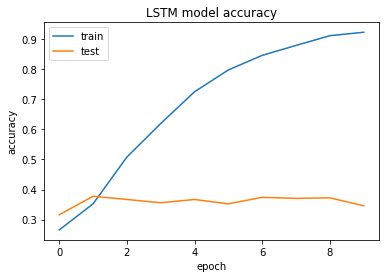

In [13]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


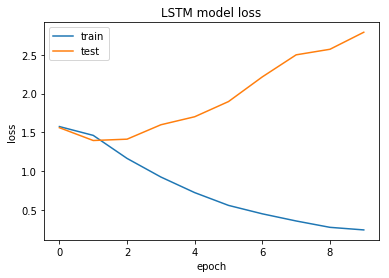

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# # This was generated re-running the model cell (because here we fit on 3 epochs only, 
#before we used 10 epochs only to plot the evolution of loss and accuracy on train et dev set

model.fit(np.concatenate([X_train, X_dev]),np.concatenate([y_train,y_dev]), batch_size=bs, nb_epoch= 3)
y_pred = model.predict(X_test)
with open("logreg_LSTM_y_test_sst.txt", "w") as f:
    for label in y_pred:
        f.write((np.argmax(label)).astype('str')+'\n')



C:\Users\Melisande\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
9645/9645 [==============================] - 48s 5ms/step - loss: 1.5688 - acc: 0.2781
Epoch 2/3
9645/9645 [==============================] - 40s 4ms/step - loss: 1.4025 - acc: 0.3980
Epoch 3/3
9645/9645 [==============================] - 41s 4ms/step - loss: 1.1138 - acc: 0.5369


## 4.3 -- innovate !

In [15]:
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer

In [19]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

encoder = Tokenizer()
encoder.fit_on_texts(SST_train)

X_train = encoder.texts_to_sequences(SST_train)
X_test = encoder.texts_to_sequences(SST_test)
X_dev = encoder.texts_to_sequences(SST_dev)



In [20]:
#padding input data
from keras.preprocessing.sequence import pad_sequences
maxseqlen = np.max([len(x) for x in X_train+X_test+X_dev])
X_train = pad_sequences(X_train, maxlen=maxseqlen, padding='pre')
X_test  = pad_sequences(X_test, maxlen=maxseqlen, padding='pre')
X_dev = pad_sequences(X_dev, maxlen=maxseqlen, padding='pre')

In [31]:

embed_dim  = 64  # word embedding dimension
nhid       = 128 # number of hidden units in the LSTM
nhid_dense = 64 # number of hidden units in the dense layers
vocab_size = 100000#len(encoder.word_index)+1  # size of the vocabulary
dropout_rate = 0.5
n_classes  = 5


model2 = Sequential()
model2.add(Embedding(vocab_size, embed_dim))
model2.add(Bidirectional(LSTM(nhid, dropout_W=dropout_rate)))#, dropout_U=0.2)))
#model2.add(Dense(64, activation='relu'))
#model2.add(Dropout(0.5))
model2.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model2.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model2.summary())


C:\Users\Melisande\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.5)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 64)          6400000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1285      
Total params: 6,598,917
Trainable params: 6,598,917
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
bs = 64
n_epochs = 10
history = model2.fit(X_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_dev, y_dev))

C:\Users\Melisande\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 60s 7ms/step - loss: 1.5593 - acc: 0.2851 - val_loss: 1.5060 - val_acc: 0.3479
Epoch 2/10
8544/8544 [==============================] - 64s 7ms/step - loss: 1.3530 - acc: 0.4151 - val_loss: 1.3713 - val_acc: 0.3869
Epoch 3/10
8544/8544 [==============================] - 62s 7ms/step - loss: 1.1017 - acc: 0.5232 - val_loss: 1.3790 - val_acc: 0.3933
Epoch 4/10
8544/8544 [==============================] - 59s 7ms/step - loss: 0.8682 - acc: 0.6482 - val_loss: 1.6524 - val_acc: 0.3942
Epoch 5/10
8544/8544 [==============================] - 59s 7ms/step - loss: 0.6380 - acc: 0.7589 - val_loss: 1.6881 - val_acc: 0.3669
Epoch 6/10
8544/8544 [==============================] - 59s 7ms/step - loss: 0.4761 - acc: 0.8256 - val_loss: 2.0423 - val_acc: 0.3660
Epoch 7/10
8544/8544 [==============================] - 58s 7ms/step - loss: 0.3629 - acc: 0.8699 - val_loss: 2.2331 - val_acc: 0.3579
Epoch 8

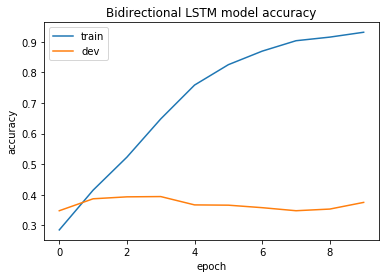

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Bidirectional LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

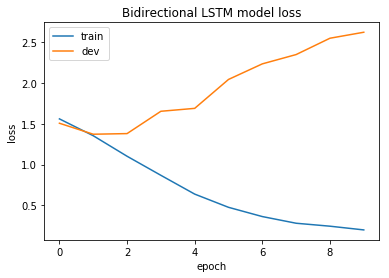

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bidirectional LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [32]:
# This was generated re-running the model cell before (because here we fit on 4 epochs only, 
#before we used 10 epochs only to plot the evolution of loss and accuracy on train et dev set)
model2.fit(np.concatenate([X_train, X_dev]),np.concatenate([y_train,y_dev]), batch_size=bs, nb_epoch= 4)
y_pred = model2.predict(X_test)
with open("bidirectional_LSTM_y_test_sst.txt", "w") as f:
    for label in y_pred:
        f.write((np.argmax(label)).astype('str')+'\n')


C:\Users\Melisande\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/4
9645/9645 [==============================] - 62s 6ms/step - loss: 1.5557 - acc: 0.2911
Epoch 2/4
9645/9645 [==============================] - 57s 6ms/step - loss: 1.3381 - acc: 0.4202
Epoch 3/4
9645/9645 [==============================] - 57s 6ms/step - loss: 1.0883 - acc: 0.5370
Epoch 4/4
9645/9645 [==============================] - 58s 6ms/step - loss: 0.8468 - acc: 0.6600
